In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
BATCH_SIZE = 16

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.p1 = nn.MaxPool2d(2, return_indices=True)
        self.c2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.p2 = nn.MaxPool2d(2, return_indices=True)
        self.c3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool2d(2, return_indices=True)

        self.c4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.p4 = nn.MaxUnpool2d(2)
        self.c5 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.p5 = nn.MaxUnpool2d(2)
        self.c6 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.p6 = nn.MaxUnpool2d(2)
        self.c7 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.c1(x))
        x, i1 = self.p1(x)
        x = F.relu(self.c2(x))
        x, i2 = self.p2(x)
        x = F.relu(self.c3(x))
        x, i3 = self.p3(x)

        x = F.relu(self.c4(x))
        x = self.p4(x, i3)
        x = F.relu(self.c5(x))
        x = self.p5(x, i2)
        x = F.relu(self.c6(x))
        x = self.p6(x, i1)
        x = F.sigmoid(self.c7(x))

        return x
net_ae1 = Autoencoder1().cuda()

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
import torch.optim as optim

loosFunction = nn.BCELoss()
optimizer = optim.Adam(net_ae1.parameters(), lr=0.001)

In [5]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = data[0].cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_ae1(inputs)
        loss = loosFunction(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


RuntimeError: Shape of input must match shape of indices

In [61]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def imshow(img):
    figure(dpi=130)
    img = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.show()

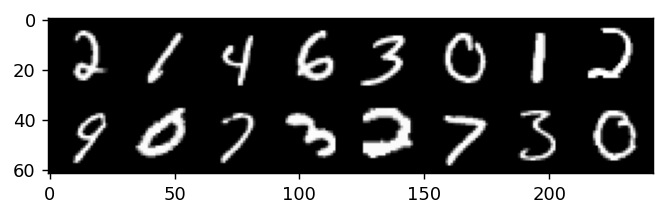

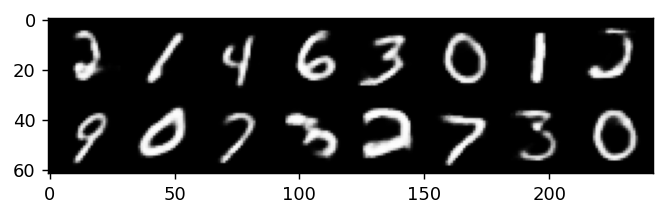

In [91]:
dataiter = iter(trainloader)
data = dataiter.next()[0]

imshow(torchvision.utils.make_grid(data))

net_ae1.cpu()
data = net_ae1(data.view(BATCH_SIZE, 28*28)).view(BATCH_SIZE, 1, 28, 28)
imshow(torchvision.utils.make_grid(data.detach()))

In [90]:
class IsItGen(nn.Module):
    def __init__(self):
        super(IsItGen, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.c2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, stride=2)
        self.c3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.c4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
        self.l1 = nn.Linear(in_features=32*4*4, out_features=1)
        


    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = F.relu(self.c5(x))
        x = torch.sigmoid(self.l1(x.view(-1, 32*4*4)))

        return x
net_iig = IsItGen().cuda()

In [91]:
loosFunction = nn.BCELoss()
optimizer = optim.Adam(net_iig.parameters(), lr=0.001)

In [94]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # POS
#         inputs = data[0].cuda() + torch.rand(inputs.shape).cuda()
#         inputs /= torch.max(inputs)
#         inputs.cuda()
        inputs = data[0].cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_iig(inputs)
        label = torch.ones(outputs.shape).float().cuda()
        loss = loosFunction(outputs, label)
        loss.backward()
        optimizer.step()
        
        #NEG
        inputs = torch.rand(inputs.shape).cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_iig(inputs)
        label = torch.zeros(outputs.shape).float().cuda()
        loss = loosFunction(outputs, label)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 0.000
[2,  2000] loss: 0.000
[3,  2000] loss: 0.000


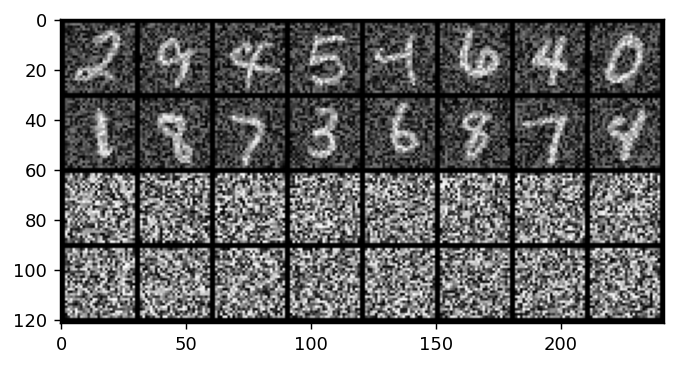

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [2.1590e-13],
        [1.8728e-12],
        [6.5857e-13],
        [5.1145e-13],
        [3.9679e-13],
        [4.1186e-14],
        [1.7298e-13],
        [3.4880e-13],
        [9.0432e-14],
        [1.6557e-13],
        [7.2068e-13],
        [1.2718e-12],
        [4.3167e-14],
        [7.2317e-12],
        [7.6486e-13],
        [4.3688e-12]], grad_fn=<SigmoidBackward>)


In [96]:
dataiter = iter(trainloader)
data = dataiter.next()[0] + torch.rand(inputs.shape)
data /= torch.max(data)
data = torch.cat((data, torch.rand(inputs.shape)))

imshow(torchvision.utils.make_grid(data))

net_iig.cpu()
data = net_iig(data)
print(data)

In [73]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()
print(output)

tensor(2.0765, grad_fn=<MseLossBackward>)
